# **Importing Data**

In [93]:
import os
from PIL import Image, ImageFilter

women_dataset = 'D:/CUFE_Courses/3-Senior1/Spring2023/CMPN450_Pattern-Recognition-&-Neural-Networks/Project/Dataset_0-5/Women'
men_dataset = 'D:/CUFE_Courses/3-Senior1/Spring2023/CMPN450_Pattern-Recognition-&-Neural-Networks/Project/Dataset_0-5/men'

images_paths = []
# dataset_labels = []
classes_sizes=[]
corrupted=0
corrupted_imgs=[]
for i in range(6):
  women_folder_path = os.path.join(women_dataset, str(i))
  men_folder_path = os.path.join(men_dataset, str(i))
  # Get the file paths in the folders
  women_files = [os.path.join(women_folder_path, f) for f in os.listdir(women_folder_path) if os.path.isfile(os.path.join(women_folder_path, f))]
  men_files = [os.path.join(men_folder_path, f) for f in os.listdir(men_folder_path) if os.path.isfile(os.path.join(men_folder_path, f))]

  imgs = women_files + men_files
  for img in imgs:
    if not img.endswith(".JPG"):          # in case of desktop.ini file or any other file
        continue

    try:
        temp = Image.open(img)
    except (IOError, SyntaxError) as e:   # in case of corrupted images
        print('Bad file:', temp)
        corrupted+=1
        continue 
    path = img.split('/')
    images_paths.append(img)
    
    
  classes_sizes.append(len(imgs))    
print("Total number of images = ", len(images_paths))
print("Number of corrupted images or desktop.ini file = ", corrupted)
print("Number of images per class = ", classes_sizes)

Bad file: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4608x2592 at 0x1E6E09BB700>
Bad file: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4608x2592 at 0x1E6E09BB700>
Bad file: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4608x2592 at 0x1E6F50391B0>
Bad file: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4608x2592 at 0x1E6F50391B0>
Bad file: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4608x2592 at 0x1E6FEDC3FA0>
Bad file: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4608x2592 at 0x1E6FEBBC5E0>
Total number of images =  1821
Number of corrupted images or desktop.ini file =  6
Number of images per class =  [289, 302, 312, 320, 305, 311]


In [58]:
import random

random.seed(42)
random.shuffle(images_paths)
dataset_labels = []
for img in images_paths:
  path=img.split('/')[-1].split('\\')
  dataset_labels.append(path[1])

'5'

# **Splitting Data (Training 70%, Validation 10%, Testing 20%)**

In [59]:
from sklearn.model_selection import train_test_split

# splitting training into 80% and testing into 20%
train_paths, test_paths, train_labels, test_labels = train_test_split(images_paths, dataset_labels, test_size=0.2, random_state=42)

# splitting training into 70% and validation into 10%
train_paths, validation_paths, train_labels, validation_labels = train_test_split(train_paths, train_labels, test_size=0.1, random_state=42)

print(len(train_paths), len(validation_paths), len(test_paths))

# check
total = len(train_paths) + len(validation_paths) + len(test_paths)
print(total == len(images_paths))

1310 146 365
True


# **Image Pre-processing**

In [60]:
import numpy as np
import cv2 as cv

# Define the target size for the images
target_size = (200, 200)

def image_preprocess(img_path):
    # Load the image
    image = cv.imread(img_path)

    # Resize the image to the target size
    resized_img = cv.resize(image, target_size)

    # Convert the resized image to grayscale
    gray_img = cv.cvtColor(resized_img, cv.COLOR_BGR2GRAY)

    # Normalize the pixel values to be between 0 and 1
    # normalized_img  = gray_img / 255.0
    normalized_img = (gray_img - np.min(gray_img)) * 255.0 / (np.max(gray_img) - np.min(gray_img))

    return resized_img, gray_img, normalized_img    # return the original and the preprocessed images


Image shape after preprocessing =  (200, 200)


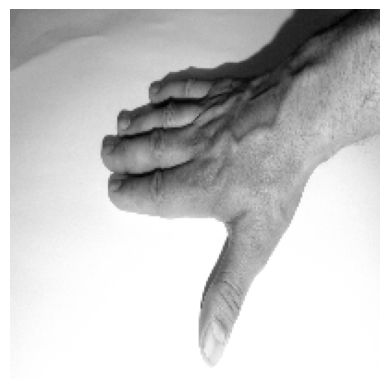

True

In [61]:
import matplotlib.pyplot as plt

resized, gray, norm = image_preprocess(images_paths[167])
print("Image shape after preprocessing = ", norm.shape)

# Display the original and processed images
# cv.imshow('Original Image', norm)
plt.axis("off")
plt.imshow(norm, cmap='gray')
plt.show()
cv.imwrite("Preprocessed_Image.JPG", norm)

# **Image Segmentation**

In [62]:
def image_segmentation(img):
    # Apply Gaussian blur to remove noise (optional)
    img = cv.GaussianBlur(img, (5, 5), 0)

    # Apply Otsu's thresholding to get binary image
    # _, thresh = cv.threshold(img, 75, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    # thresh = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)

    hsvim = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    lower = np.array([0, 48, 80], dtype = "uint8")
    upper = np.array([20, 255, 255], dtype = "uint8")
    skinRegionHSV = cv.inRange(hsvim, lower, upper)
    ret,thresh = cv.threshold(skinRegionHSV,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

    return thresh

In [63]:
# Convert the normalized image to uint8
# uint8_img = cv.convertScaleAbs(norm, alpha=(255.0))
uint8_img = norm.astype(np.uint8)

segmented_img = image_segmentation(resized)
print("Image shape after segmentation = ", segmented_img.shape)
cv.imwrite("Segmented_Image.JPG", segmented_img)

Image shape after segmentation =  (200, 200)


True

# **Morphological Operations**

In [64]:
def morphological_operations(img):
    # Define the kernel for morphological operations
    kernel = np.ones((5,5),np.uint8)

    # Perform dilation operation on the image
    dilated_img = cv.dilate(img, kernel, iterations=1)

    # Perform erosion operation on the image
    eroded_img = cv.erode(img, kernel, iterations=1)

    # Perform opening operation on the image
    opening_img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)

    # Perform closing operation on the image
    closing_img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)

    return closing_img

In [65]:
noise_removal = morphological_operations(segmented_img)
print("Image shape after morphological operations = ", noise_removal.shape)
cv.imwrite("Noise_Removal_Image.JPG", noise_removal)

Image shape after morphological operations =  (200, 200)


True

# **Canny Edge Detection**

In [66]:
def canny_edge_detection(img):
    # Apply Gaussian blur to reduce noise in the image
    img_blur = cv.GaussianBlur(img, (5,5), 0)

    # Perform Canny edge detection
    edges = cv.Canny(img_blur, 100, 200)

    return edges

In [67]:
edges = canny_edge_detection(noise_removal)
print("Image shape after Canny edge detection = ", edges.shape)
cv.imwrite("Edged_Image.JPG", edges)

Image shape after Canny edge detection =  (200, 200)


True

# **Feature Extraction**

In [68]:
def EOH(img):
    # Compute the gradient magnitude and direction using Sobel operators
    dx = cv.Sobel(img, cv.CV_32F, 1, 0)
    dy = cv.Sobel(img, cv.CV_32F, 0, 1)
    mag, angle = cv.cartToPolar(dx, dy, angleInDegrees=True)

    # Define the number of histogram bins and range
    hist_bins = 9
    hist_range = (0, 180)

    # Compute the histogram of gradient orientations for each cell of a 4x4 grid
    cell_size = (img.shape[0] // 4, img.shape[1] // 4)
    hog_descriptor = np.zeros((4, 4, hist_bins))
    for i in range(4):
        for j in range(4):
            cell_mag = mag[i*cell_size[0]: (i+1)*cell_size[0], j*cell_size[1]: (j+1)*cell_size[1]]
            cell_angle = angle[i*cell_size[0]: (i+1)*cell_size[0], j*cell_size[1]: (j+1)*cell_size[1]]
            hist, _ = np.histogram(cell_angle, bins=hist_bins, range=hist_range, weights=cell_mag)
            hog_descriptor[i, j] = hist

    # Flatten the descriptor to obtain a feature vector for the entire image
    hog_descriptor = hog_descriptor.flatten()

    # Normalize the feature vector using L2 normalization
    hog_descriptor /= np.linalg.norm(hog_descriptor)

    return hog_descriptor

In [92]:
features = EOH(edges)
print("Features vector shape = ", features.shape)
print("Features vector = ", features)

Features vector shape =  (144,)
Features vector =  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.33272166 0.01006106 0.13044499 0.01422848 0.13048379 0.09959937
 0.07953963 0.         0.16459467 0.06560697 0.         0.09862914
 0.16830056 0.23847037 0.14401101 0.23543731 0.03018317 0.1146765
 0.03222625 0.         0.01908951 0.03851802 0.07199106 0.01422848
 0.00954475 0.         0.00899888 0.22369908 0.01006106 0.11771866
 0.         0.15748043 0.06402817 0.02863427 0.         0.10798658
 0.14313346 0.02012211 0.03499744 0.         0.         0.
 0.00636317 0.         0.08098994 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.20351084 0.01006106 0.03499744 0.         0.01799776 0.08415028
 0.12408182 0.01006106 0.16605499 0.0224972  0.         0.00954476
 0.         0.10798658 0.24950401 0.09544755 0.         0.02

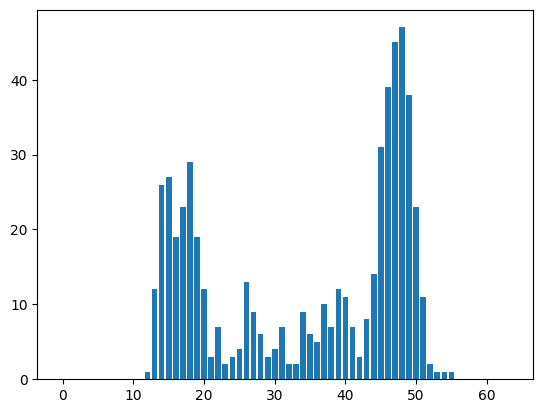

In [70]:
# Initialize number of histogram bins
k = 64
bin_width = 256 // k

# Initialize histogram bins
histogram = np.zeros(k, dtype=np.int32)

# Loop over every edge pixel in Iedge
for i in range(edges.shape[0]):
    for j in range(edges.shape[1]):
        # Check if the pixel is an edge pixel
        if edges[i, j] != 0:
            # Find corresponding gray level intensity in Igray
            intensity = gray[i, j]
            # Determine the bin index for the intensity
            bin_index = intensity // bin_width
            # Increment the count of the corresponding bin
            histogram[bin_index] += 1

# Plot the histogram
plt.bar(range(k), histogram)
plt.show()

In [71]:
train_features = []
for img_path in train_paths:
    resized, gray, norm = image_preprocess(img_path)
    segmented_img = image_segmentation(resized)
    noise_removal = morphological_operations(segmented_img)
    edges = canny_edge_detection(noise_removal)
    features = EOH(edges)
    train_features.append(features)

In [72]:
validation_features = []
for img_path in validation_paths:
    resized, gray, norm = image_preprocess(img_path)
    segmented_img = image_segmentation(resized)
    noise_removal = morphological_operations(segmented_img)
    edges = canny_edge_detection(noise_removal)
    features = EOH(edges)
    validation_features.append(features)

In [73]:
test_features = []
for img_path in test_paths:
    resized, gray, norm = image_preprocess(img_path)
    segmented_img = image_segmentation(resized)
    noise_removal = morphological_operations(segmented_img)
    edges = canny_edge_detection(noise_removal)
    features = EOH(edges)
    test_features.append(features)

In [74]:
import pandas as pd

train_features_pd = pd.Series(train_features)
train_labels_pd = pd.Series(train_labels)
train_df = pd.concat([train_features_pd, train_labels_pd], axis=1)  
train_df.columns = ['features', 'labels']
train_df.to_csv('Datasets/train.csv', index=False)

validation_features_pd = pd.Series(validation_features)
validation_labels_pd = pd.Series(validation_labels)
validation_df = pd.concat([validation_features_pd, validation_labels_pd], axis=1)
validation_df.columns = ['features', 'labels']
validation_df.to_csv('Datasets/validation.csv', index=False)

test_features_pd = pd.Series(test_features)
test_labels_pd = pd.Series(test_labels)
test_df = pd.concat([test_features_pd, test_labels_pd], axis=1)
test_df.columns = ['features', 'labels']
test_df.to_csv('Datasets/test.csv', index=False)


# **Classification**

In [84]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the SVM model
svm_model = SVC(kernel='rbf', C=1.0, decision_function_shape='ovr')
svm_model.fit(train_features, train_labels)

# Predict the class labels on the test set
y_pred = svm_model.predict(validation_features)

# Evaluate the accuracy of the model
accuracy = accuracy_score(validation_labels, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.7054794520547946


In [79]:
from sklearn.linear_model import LogisticRegression

# create a logistic regression model
lr = LogisticRegression()

# fit the model on the training data
lr.fit(train_features, train_labels)

# predict the labels of the test set
y_pred = lr.predict(validation_features)

# Evaluate the accuracy of the model
accuracy = accuracy_score(validation_labels, y_pred)
print("Accuracy: ", accuracy)


Accuracy:  0.5821917808219178


In [87]:
from sklearn.neighbors import KNeighborsClassifier

# create a KNN classifier with k=3
knn = KNeighborsClassifier(n_neighbors=10)

# fit the model on the training data
knn.fit(train_features, train_labels)

# predict on the test data
y_pred = knn.predict(validation_features)

# Evaluate the accuracy of the model
accuracy = accuracy_score(validation_labels, y_pred)
print("Accuracy: ", accuracy)


Accuracy:  0.6643835616438356


In [90]:
from sklearn.ensemble import RandomForestClassifier

# Create the random forest classifier object
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rfc.fit(train_features, train_labels)

# Make predictions on the testing data
y_pred = rfc.predict(validation_features)

# Evaluate the accuracy of the model
accuracy = accuracy_score(validation_labels, y_pred)
print("Accuracy: ", accuracy)


Accuracy:  0.678082191780822


# **Confusion Matrix**

In [88]:
from sklearn.metrics import confusion_matrix

# y_true contains the true labels of the test data
# y_pred contains the predicted labels of the test data
# classes contains the names of the classes
classes = ['0', '1', '2', '3', '4', '5']
cm = confusion_matrix(validation_labels, y_pred, labels=classes)

# Print the confusion matrix
print(cm)


[[24  0  0  1  0  0]
 [ 2 17  3  0  1  1]
 [ 0  5 15  5  3  0]
 [ 0  2  7  8  7  2]
 [ 1  1  0  4 15  1]
 [ 0  0  1  0  2 18]]


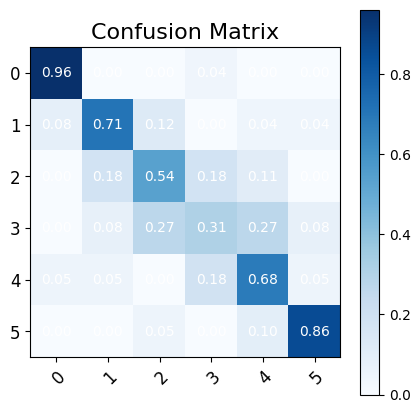

In [89]:
# normalize the confusion matrix
conf_matrix = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(conf_matrix, cmap='Blues')

# set the axis labels
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, fontsize=12)
ax.set_yticklabels(classes, fontsize=12)

# rotate the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# set the text labels in each cell
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, format(conf_matrix[i, j], '.2f'),
                       ha="center", va="center", color="white")

# set the plot title and show the color bar
ax.set_title("Confusion Matrix", fontsize=16)
plt.colorbar(im)

# display the plot
plt.show()